In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import mixed_precision









# -------------------------------------
# 2. CONFIGURACIÓN
# -------------------------------------

In [75]:
mixed_precision.set_global_policy('mixed_float16')

# Parámetros
img_size = (160, 160)
batch_size = 32
epochs = 20
seed = 123
train_dir = '../../dataset/dataset/train'
model_path = 'mobilenetv2_derma_v1.keras'

# -------------------------------------
# 3. DATA AUGMENTATION Y GENERADORES
# -------------------------------------

In [76]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)
# Obtener número de clases
class_names = train_ds.class_names
num_classes = len(class_names)
print("Clases:", class_names)


Found 15557 files belonging to 23 classes.
Using 12446 files for training.
Found 15557 files belonging to 23 classes.
Using 3111 files for validation.
Clases: ['acne_rosacea', 'atopic_dermatitis', 'bacterial_infections', 'bullous_disease', 'contact_dermatitis', 'eczema', 'exanthems_drug_eruptions', 'fungal_infections', 'hair_diseases', 'keratosis_carcinoma', 'lupus_connective_tissues', 'melanoma_moles', 'nail_disease', 'pigmentation_disorders', 'psoriasis_lichen', 'scabies_lyme', 'seborrheic_keratosis', 'stds_herpes_hpv', 'systemic_disease', 'urticaria', 'vascular_tumors', 'vasculitis', 'warts_viral']


In [77]:

# ---------------------------------------
# CÁLCULO DE PESOS POR CLASE
# ---------------------------------------
from sklearn.utils.class_weight import compute_class_weight

# Contar imágenes por clase
image_counts = []
for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    count = len(os.listdir(class_path))
    image_counts.append(count)

# Crear vector de etiquetas reales
y_train = []
for i, count in enumerate(image_counts):
    y_train += [i] * count
y_train = np.array(y_train)

# Calcular pesos
weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight = dict(enumerate(weights))

print("Pesos por clase:", class_weight)

Pesos por clase: {0: 0.8052277432712215, 1: 1.3832133013247978, 2: 2.348580917874396, 3: 1.5098020186335404, 4: 2.601505016722408, 5: 0.5476852666784017, 6: 1.6742359018510546, 7: 0.5203010033444816, 8: 2.830089139530653, 9: 0.5886782457335301, 10: 1.610455486542443, 11: 1.4608883463235984, 12: 0.650376254180602, 13: 1.1908297611757501, 14: 0.48141729846820364, 15: 1.569353374356905, 16: 0.4933561665556718, 17: 1.670101986044015, 18: 1.116157267900703, 19: 3.1905250205086135, 20: 1.4033014613025439, 21: 1.625940635451505, 22: 0.6228280887180719}


In [ ]:
# Optimización de rendimiento
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=tf.data.AUTOTUNE)

# Configuración de caché y prefetch
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [ ]:
# Modelo base (preentrenado)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # congelamos capas base

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])


# Modelo completo (sin preprocessing dentro)
model = models.Sequential([
    base_model,
    data_augmentation,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

# Compilar modelo
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Callbacks
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint(model_path, save_best_only=True)
]

# Entrenamiento
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks,
    class_weight=class_weight 
)

Epoch 1/20
389/389 ━━━━━━━━━━━━━━━━━━━━ 441s 1s/step - accuracy: 0.1846 - loss: 2.9048 - val_accuracy: 0.2996 - val_loss: 2.3614
Epoch 2/20
389/389 ━━━━━━━━━━━━━━━━━━━━ 436s 1s/step - accuracy: 0.3008 - loss: 2.3495 - val_accuracy: 0.3311 - val_loss: 2.2717
Epoch 3/20
389/389 ━━━━━━━━━━━━━━━━━━━━ 425s 1s/step - accuracy: 0.3577 - loss: 2.1624 - val_accuracy: 0.3549 - val_loss: 2.2054
Epoch 4/20
389/389 ━━━━━━━━━━━━━━━━━━━━ 405s 1s/step - accuracy: 0.3909 - loss: 2.0211 - val_accuracy: 0.3581 - val_loss: 2.1991
Epoch 5/20
389/389 ━━━━━━━━━━━━━━━━━━━━ 418s 1s/step - accuracy: 0.4277 - loss: 1.8813 - val_accuracy: 0.3664 - val_loss: 2.1735
Epoch 6/20
389/389 ━━━━━━━━━━━━━━━━━━━━ 420s 1s/step - accuracy: 0.4599 - loss: 1.7655 - val_accuracy: 0.3610 - val_loss: 2.1918
Epoch 7/20
389/389 ━━━━━━━━━━━━━━━━━━━━ 415s 1s/step - accuracy: 0.4911 - loss: 1.6550 - val_accuracy: 0.3706 - val_loss: 2.1962
Epoch 8/20
389/389 ━━━━━━━━━━━━━━━━━━━━ 412s 1s/step - accuracy: 0.5203 - loss: 1.5501 - val_accu

Found 4002 files belonging to 23 classes.
126/126 ━━━━━━━━━━━━━━━━━━━━ 121s 948ms/step
🧾 Clasification Report:

                          precision    recall  f1-score   support

            acne_rosacea       0.49      0.64      0.56       312
       atopic_dermatitis       0.34      0.24      0.28       123
    bacterial_infections       0.33      0.03      0.05        73
         bullous_disease       0.13      0.05      0.08       113
      contact_dermatitis       0.15      0.03      0.05        65
                  eczema       0.31      0.42      0.36       309
exanthems_drug_eruptions       0.34      0.21      0.26       101
       fungal_infections       0.25      0.45      0.32       325
           hair_diseases       0.45      0.33      0.38        60
     keratosis_carcinoma       0.45      0.38      0.41       288
lupus_connective_tissues       0.12      0.06      0.08       105
          melanoma_moles       0.61      0.24      0.35       116
            nail_disease     

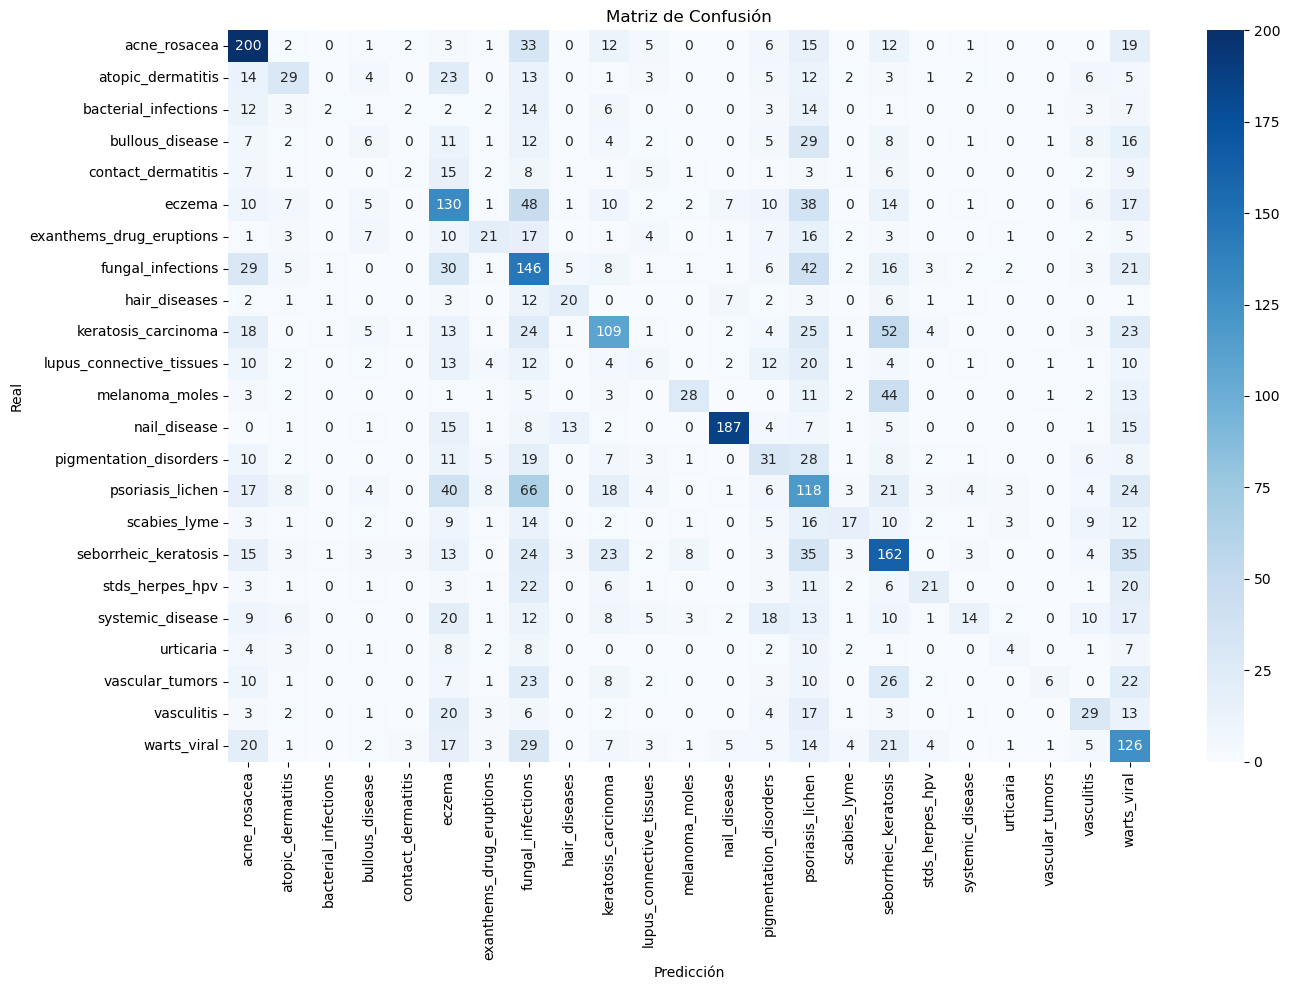

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Rutas
test_dir = '../dataset/dataset/test'

# Cargar modelo entrenado
model = tf.keras.models.load_model(model_path)

# Cargar dataset de test
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False  # MUY IMPORTANTE para alinear predicciones con etiquetas
)

# Obtener nombres de clase
class_names = test_ds.class_names
num_classes = len(class_names)

# Prefetch para acelerar
AUTOTUNE = tf.data.AUTOTUNE
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Obtener predicciones
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# Obtener etiquetas reales
y_true = np.concatenate([y.numpy() for x, y in test_ds])

# Reporte de clasificación
print("🧾 Clasification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(14, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
